# Changes suggested:

> Change the zomato, yelp, trip advisor column renaming part
> Change the graphs which has Number Of Restaurant as fractions.
> Remove the duplicate restaurants from the graphs which 

# Install the below dependencies

In [1]:
##Run the below block to initialize all the dependencies
import requests
from pprint import pprint
import pandas as pd
from pandas import ExcelWriter
import io, time, json
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import scipy
import warnings
import io, time, json
from bs4 import BeautifulSoup
import nltk
from nltk.corpus import stopwords
from nltk import punkt
import wordcloud
from wordcloud import WordCloud
import re
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

In [2]:
##The below block of code is used to read the API Key required for extracting data from Yelp fusion API.

def read_api_key(filepath):
    """
    Read the Yelp API Key from file.
    
    Args:
        filepath (string): File containing API Key
    Returns:
        api_key (string): The API Key
    """
    
    with open('api_key.txt', 'r') as f:
        return f.read().replace('\n','')

def read_api_key_zomato(filepath):
    """
    Read the Yelp API Key from file.
    
    Args:
        filepath (string): File containing API Key
    Returns:
        api_key (string): The API Key
    """
    
    with open('api_key_zomato.txt', 'r') as f:
        return f.read().replace('\n','')

# Yelp Data Extraction
The below function takes in the api_key and the query and returns a total of 1000 restaurants along with their parameters including Name, Rating, Price, Reveiw Count, Url, Category, Zip.

In [3]:
##The function below is used to retrieve all the restaurants from the YELP API.

def all_restaurants(api_key, query):
    """
    Retrieve ALL the restaurants on Yelp for a given query.

    Args:
        query (string): Search term

    Returns:
        results (list): list of dicts representing each business
    """
    
    offsetno=0
    total =0
    output=[]
    headers = {        
        "authorization": 'Bearer %s' % api_key, # for the yelp API     
    }
    while (offsetno < 1000):
        params = { #parameters are case sensitive!
            "location": query,
            "limit": 20,
            "offset": offsetno,
            "categories": "restaurants"
            
        }
    
        response = requests.get('https://api.yelp.com/v3/businesses/search',
                            headers=headers, params=params)
        result = response.json()
        try:
            output.append( result['businesses'])
        except KeyError:
            print(result)
            return output
        offsetno =offsetno + 20
        total = result['total']
        #print (offsetno)
        #print (len(output))
    return(output)

In [60]:
## Reading the API Key for accessing the Yelp API below. Passing the query parameter as Miami to select all
## restaurants from Miami.

api_key = read_api_key('api_key.txt')
data = all_restaurants(api_key, 'Miami')
new_data = {}
new_data["name"]=[]
new_data["rating"]=[]
new_data["price"]=[]
new_data["review_count"]=[]
new_data["url"]=[]
new_data["category"]=[]
new_data["zip"]=[]
alldata=[]
ids=[]
name=[]
zips=[]
for i in data:
    for each in i:
        new_data["name"].append(each["name"])
        new_data["rating"].append(each["rating"])
        new_data["url"].append(each["url"])
        try:
            new_data["price"].append(each["price"])
        except KeyError:
            new_data["price"].append(None)

        new_data["review_count"].append(each["review_count"])
        new_data["category"].append(each["categories"][0]["title"])
        new_data["zip"].append(each["location"]["zip_code"])
        ids.append(each["id"])
        name.append(each["name"])
        zips.append(each["location"]["zip_code"])
        alldata.append(each)

yelp_raw = pd.DataFrame(alldata)
yelp_clean = pd.DataFrame(new_data)
yelp_clean['source'] = 'Yelp'

The below peice of code is executed to extract the actual value for prices. This is mandatory to ensure 
that prices have integer values and can be used for visualization later.

In [62]:
##Clean the price data coming from the YELP API.
##Please run the block only after the above block is complete.

def price(df):
    try:
        df["price"]= len(df["price"])
    except:
        df["price"]=""
    return df
yelp_clean= yelp_clean.apply(price,axis=1)

The below function hits the YELP Fusion API again and fetches reviews for the restaurants that were fetched in the 
above query. This function is being called in the code block below and the data extracted is being used
in generating the word cloud.

In [39]:
##Retreive top 3 reviews for the restaurants retrieved from YELP. 

def get_reviews(ids,name):
    headers = {        
        "authorization": 'Bearer %s' % api_key, # for the yelp API     
    }
    restau_names=[]
    output=[]
    for i in range(len(ids)):
        params = { #parameters are case sensitive!
            "locale": "en_US",
        }
        url = "https://api.yelp.com/v3/businesses/"+str(ids[i])+"/reviews"
        response = requests.get(url,
                            headers=headers,params=params)
        result = response.json()
        output.append(result["reviews"])
        restau_names.append(name[i])
    return output,restau_names

In [40]:
##Calling the function above and storing the Restaurant Name and Reviews in seperate lists.
##This takes a while a to retrieve the data as it is extracting the data from YELP.

reviews, restau_name = get_reviews(ids,name)

Writing the data fetched in the above block to a CSV, since the API call is time consuming and can be an
expensive operation to be run consecutively. 
The CSV acts as a one time data store for reviews.

In [41]:
##Writing the review data extracted from YELP to a CSV to avoid API call since, API call is time consuming.
restau=[]
text_reviews=[]
loc_zip=[]
for i in range(len(reviews)):
    for each in reviews[i]:
        text_reviews.append(each["text"])
#         print(i)
        restau.append(name[i])
        loc_zip.append(zips[i])
d = {'restau_name':restau,'zip':loc_zip,'reviews':text_reviews}
reviews_df = pd.DataFrame(d)
reviews_df.to_csv("../DataFiles/reviews_df.csv",index=False)

# Trip Advisor Data Cleaning

In [64]:
##The below code needs to be executed to clean the TripAdvisor CSV file and create a raw and clean dataset out of it.

trip_advisor_raw = pd.read_csv('../DataFiles/TripAdvisor_Data.csv')
trip_advisor_clean = trip_advisor_raw[trip_advisor_raw["City"]=="Miami"]
trip_advisor_clean = trip_advisor_clean.loc[:,["Name","Ranking","Price","Total Review","Restaurant URL","cuisine","Address",]]
trip_advisor_clean.rename(index=str,columns={"Name":"name","Ranking":"rating","Total Review":"review_count","Restaurant URL":"url","cuisine":"category","Price":"price"},inplace=True)
trip_advisor_clean['source'] = 'Trip Advisor'
trip_advisor_clean["check"] = trip_advisor_clean["Address"].str[-5:].str.isdigit()
trip_advisor_clean = trip_advisor_clean[~trip_advisor_clean.Address.isnull()]

The Zip code is Trip Advisor needs to be extracted from the address to maintain a uniformity in the cleaned data.
The below function returns the extracted zip from the address based on whether the address has a Zip or not.

In [65]:
##Extracting the Zip code from address.

def check(df):
    try:
        if df["check"]==False:
            df["new_zip"]=""
        if df["check"]==True and df["Address"][-10:].find("-")==-1:
            df["new_zip"]=df["Address"][-5:]
        if df["check"]==False and df["Address"][-10:].find("-")!=-1:
            df["new_zip"]= df["Address"][-10:][:df["Address"][-10:].find("-")]
    except AttributeError: 
        df["new_zip"]=""
    except TypeError:
        df["new_zip"]=""
        
    return df

In [66]:
## Calling the check function on the previously cleaned data.

trip_advisor_clean= trip_advisor_clean.apply(check, axis=1)

In [67]:
##Since we need to maintain a uniformity in cleaned data to Address and check columns are dropped.
##At the same time new zip column is renamed to zip

trip_advisor_clean.drop(columns=['Address', 'check'],inplace=True)
trip_advisor_clean.rename(columns={"new_zip":"zip"},inplace=True)

# Zomato Data Extraction

In [68]:
##Below block of code is used to extract the data from the Zomato API.

api_key_zomato = read_api_key_zomato('api_key_zomato.txt')

headers = {'Content-Type': 'application/json', 'user-key': api_key_zomato}
offset = 0
restaurantNameList = []
ratingList = []
votesList = []
urlList = []
categoryList = []
priceList = []
zipList = []
totalData = []
while offset < 100:
    url = 'https://developers.zomato.com/api/v2.1/search?entity_id=291&entity_type=city&start='+str(offset)+'&count=20'
    Response = requests.get(url , headers=headers)
    offset += 20
    Response_Json = Response.json()
    Array_length = Response_Json['restaurants']
    for i in range(len(Array_length)):
        totalData.append(Response_Json['restaurants'][i])
        restaurantNameList.append(Response_Json['restaurants'][i]['restaurant']['name'])
        ratingList.append(Response_Json['restaurants'][i]['restaurant']['user_rating']['aggregate_rating'])
        votesList.append(Response_Json['restaurants'][i]['restaurant']['user_rating']['votes'])
        urlList.append(Response_Json['restaurants'][i]['restaurant']['url'])
        categoryList.append(Response_Json['restaurants'][i]['restaurant']['cuisines'])
        priceList.append(Response_Json['restaurants'][i]['restaurant']['average_cost_for_two'])
        zipList.append(Response_Json['restaurants'][i]['restaurant']['location']['zipcode'])
zomato_raw = pd.DataFrame({'AllData':totalData})
zomato_clean = pd.DataFrame({'name':restaurantNameList,'rating':ratingList,'price':priceList ,'review_count':votesList,'url':urlList,'category':categoryList,'zip':zipList})
zomato_clean['source'] = 'Zomato'

In [77]:
##The below code will merge all the data frames to produce a merged dataset from the cleaned data.

Merged_data = yelp_clean.append([trip_advisor_clean,zomato_clean])

In [72]:
##Rhe below block will create the excel file with the raw,cleaned and merged data.

writer = pd.ExcelWriter('../DataFiles/Final_Data.xlsx' , engine='xlsxwriter')

yelp_raw.to_excel(writer,'Yelp_Raw',index=False)
yelp_clean.to_excel(writer,'Yelp_Clean',index=False)
trip_advisor_raw.to_excel(writer, sheet_name = ' TripAdvisor_Raw')
trip_advisor_clean.to_excel(writer, sheet_name = 'TripAdvisor_Clean')
zomato_raw.to_excel(writer,sheet_name = 'Zomato_Raw')
zomato_clean.to_excel(writer,sheet_name = 'Zomato_Clean')
Merged_data.to_excel(writer,sheet_name = 'Merged_Data')
writer.save()
writer.close()

# Visualizations

In [201]:
##Below is the code for the visualizations.
##We read the data data sheet created above below.

data = pd.ExcelFile('../DataFiles/Final_Data.xlsx')

In [156]:
##Parsing the clean sheets below

zomato = data.parse('Zomato_Clean')
yelp = data.parse('Yelp_Clean')
ta = data.parse('TripAdvisor_Clean')

# Cross tabulation charts

# Zomato Rating

In [163]:
bins = [ 2.5, 3, 3.5, 4.0, 4.5, 5.0]

zomato['ratingbucket'] = pd.cut(zomato['rating'], bins)

In [164]:
zomato = zomato.sort_values('rating', ascending=False)

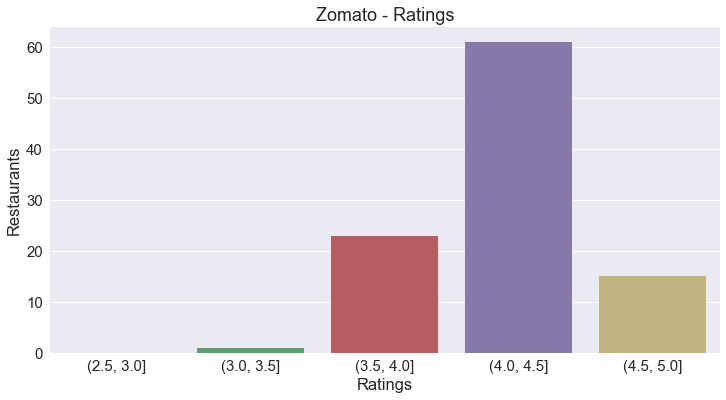

In [165]:
sns.set(font_scale= 1.5)
fig, ax = plt.subplots(figsize=(12,6))
sns.countplot(ax = ax, x='ratingbucket', data=zomato)
plt.title('Zomato - Ratings')
plt.xlabel('Ratings')
plt.ylabel('Restaurants')
plt.show()

# Zomato Price

In [161]:
zomato = zomato.sort_values('price', ascending=False)

zomato['price_segment'] = 'Cheap'
zomato['price_segment'][zomato['price'] > 50] = 'Low'
zomato['price_segment'][zomato['price'] > 100] = 'Moderate'
zomato['price_segment'][zomato['price'] > 175] = 'Expensive'

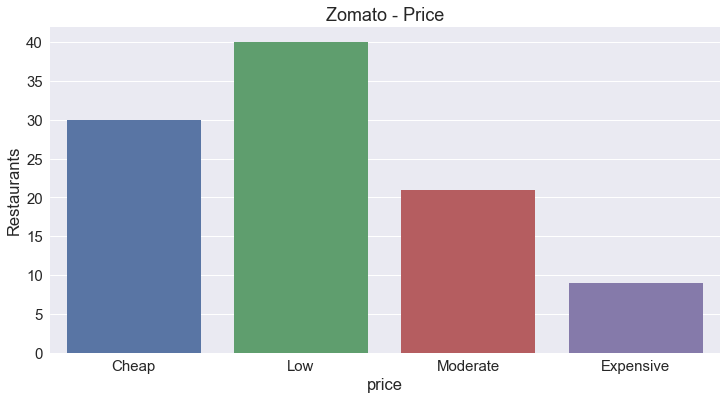

In [162]:
sns.set(font_scale= 1.5)
fig, ax = plt.subplots(figsize=(12,6))
sns.countplot(ax = ax, x='price_segment', data=zomato, order= ['Cheap','Low','Moderate','Expensive'])
ax = plt.gca()
#ax.set_xticklabels(['\$','\$$','\$$\$', '\$\$\$$'])
plt.title('Zomato - Price')
plt.xlabel('price')
plt.ylabel('Restaurants')

plt.show()

# Yelp Rating

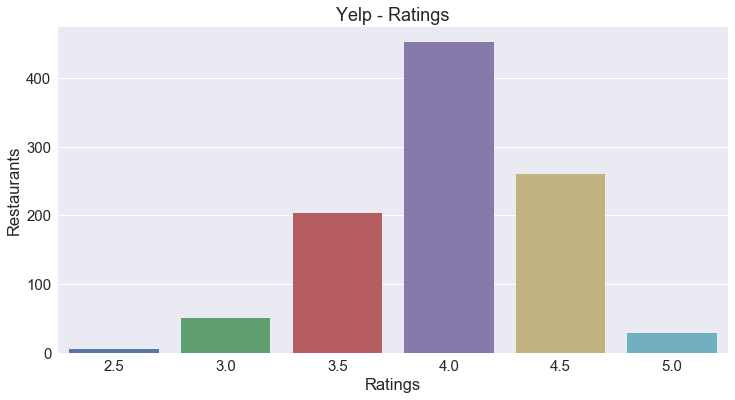

In [116]:
yelp = yelp.sort_values('rating', ascending=False)

sns.set(font_scale= 1.5)
fig, ax = plt.subplots(figsize=(12,6))
sns.countplot(ax = ax, x='rating', data=yelp)
plt.title('Yelp - Ratings')
plt.xlabel('Ratings')
plt.ylabel('Restaurants')
plt.show()

## Yelp Price

In [159]:
yelp = yelp.sort_values('price', ascending=False)

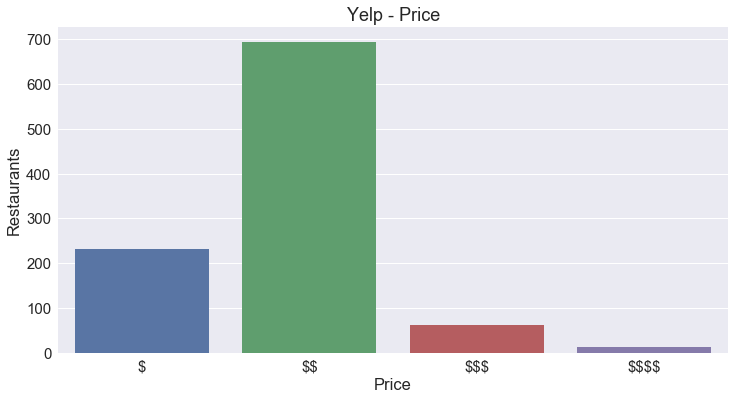

In [160]:
sns.set(font_scale= 1.5)
fig, ax = plt.subplots(figsize=(12,6))
sns.countplot(ax = ax, x='price', data=yelp)

ax = plt.gca()

ax.set_xticklabels(['\$','\$$','\$$\$', '\$\$\$$'])
plt.title('Yelp - Price')
plt.xlabel('Price')
plt.ylabel('Restaurants')

plt.show()

## Top 20 Restaurant Categories and their Rating - YELP

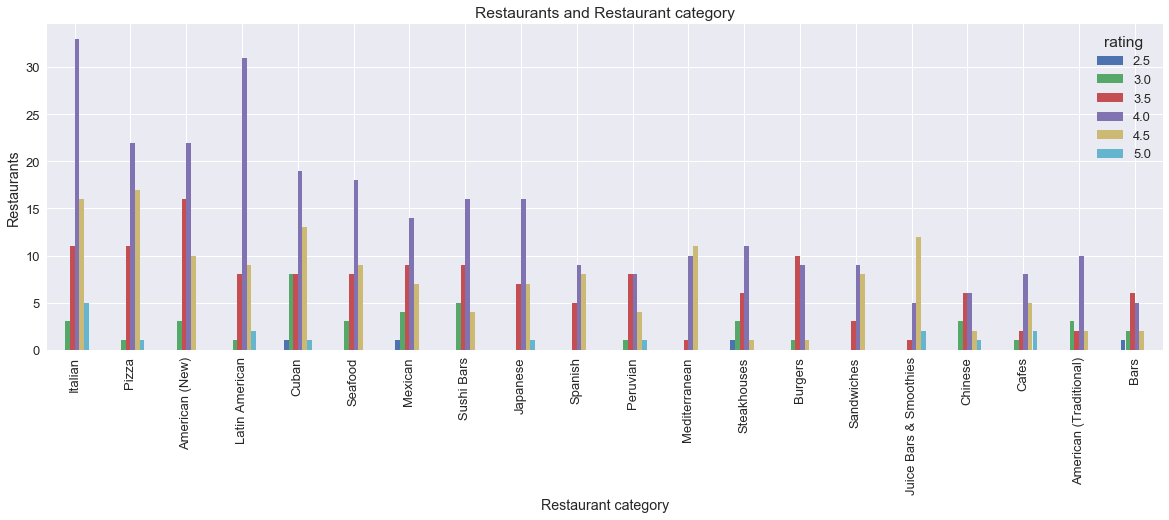

In [158]:
yelp = yelp.sort_values('rating', ascending=False)

sns.set(font_scale=1.3)
fig, ax = plt.subplots(figsize=(20,6))
df = pd.crosstab(yelp.category,yelp.rating)
df['total'] = df[2.5]+df[3.0]+ df[3.5]+ df[4.0] + df[4.5] + df[5.0]
df = df.sort_values('total', ascending=False)
del df['total']
df.head(20).plot(ax=ax, kind='bar')
plt.title('Restaurants and Restaurant category')
plt.xlabel('Restaurant category')
plt.ylabel('Restaurants')
plt.show()

## Top 20 Restaurant Categories and their Price - YELP

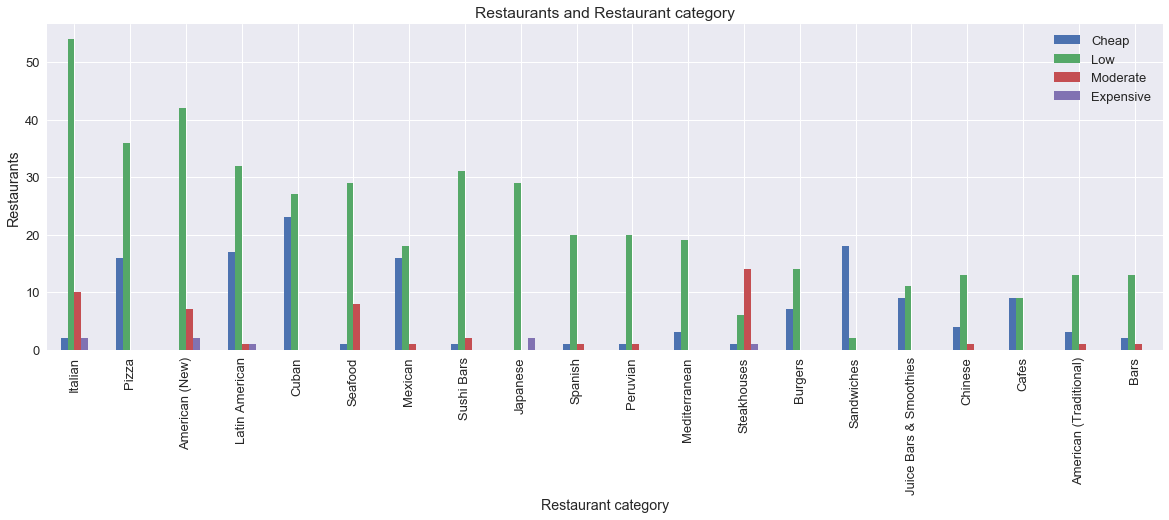

In [157]:
sns.set(font_scale=1.3)
fig, ax = plt.subplots(figsize=(20,6))
df = pd.crosstab(yelp.category,yelp.price)
df.columns = ['Cheap','Low','Moderate','Expensive']
df['total'] = df['Cheap']+df['Low']+ df['Moderate']+ df['Expensive']
df = df.sort_values('total', ascending=False)
del df['total']
df.head(20).plot(ax=ax, kind='bar')
plt.title('Restaurants and Restaurant category')
plt.xlabel('Restaurant category')
plt.ylabel('Restaurants')
plt.show()

# Top 20 Restaurant Categories and their Rating - ZOMATO

In [171]:
zomato = zomato.sort_values('rating', ascending=False)

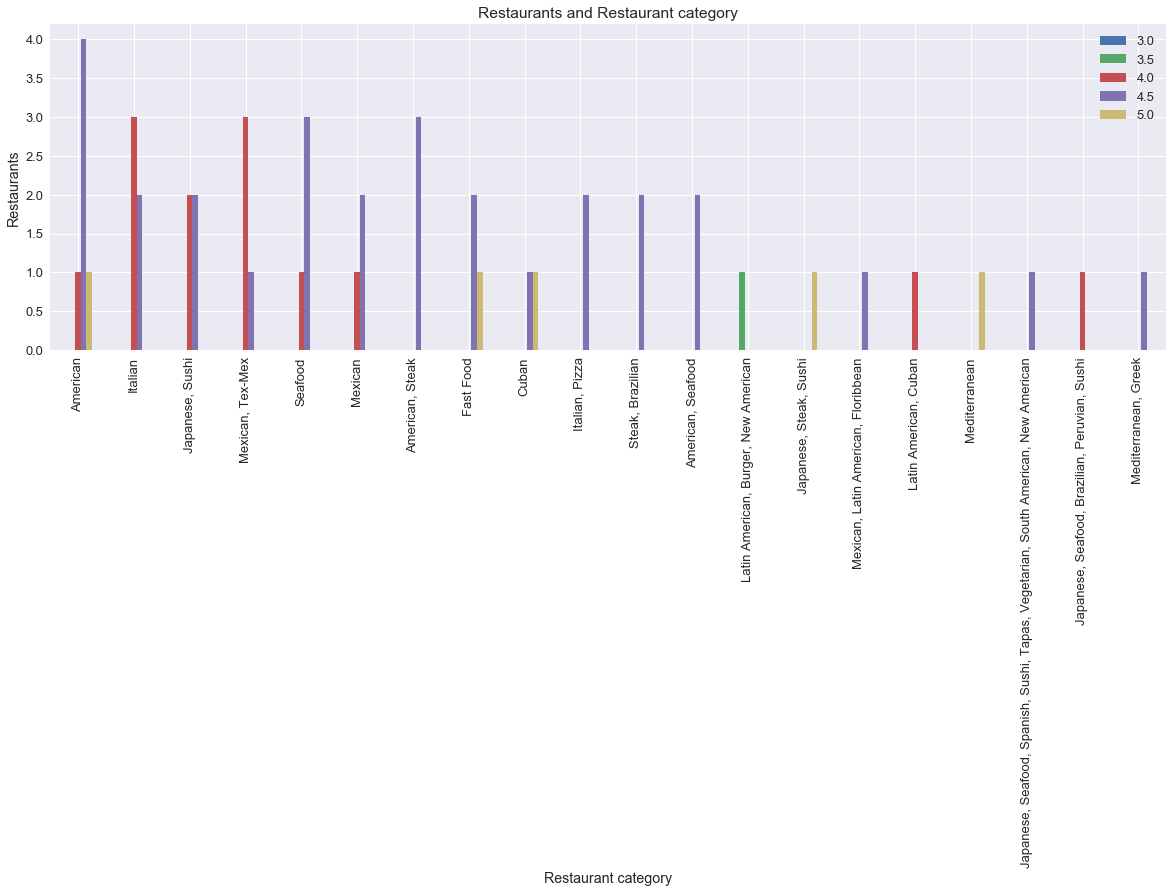

In [199]:
import matplotlib.ticker as ticker
sns.set(font_scale=1.3)
fig, ax = plt.subplots(figsize=(20,6))
df = pd.crosstab(zomato.category,zomato.ratingbucket)
df.columns = [3.0,3.5,4.0,4.5,5.0]
df['total'] = df[3.0]+ df[3.5]+ df[4.0] + df[4.5]+ df[5.0]
df = df.sort_values('total', ascending=False)
del df['total']
df.head(20).plot(ax=ax, kind='bar')
plt.title('Restaurants and Restaurant category')
# plt.xticks(np.arange(1, 5, 1.0))
plt.xlabel('Restaurant category')
plt.ylabel('Restaurants')
plt.show()

# Top 20 Restaurant Categories and their Price - ZOMATO

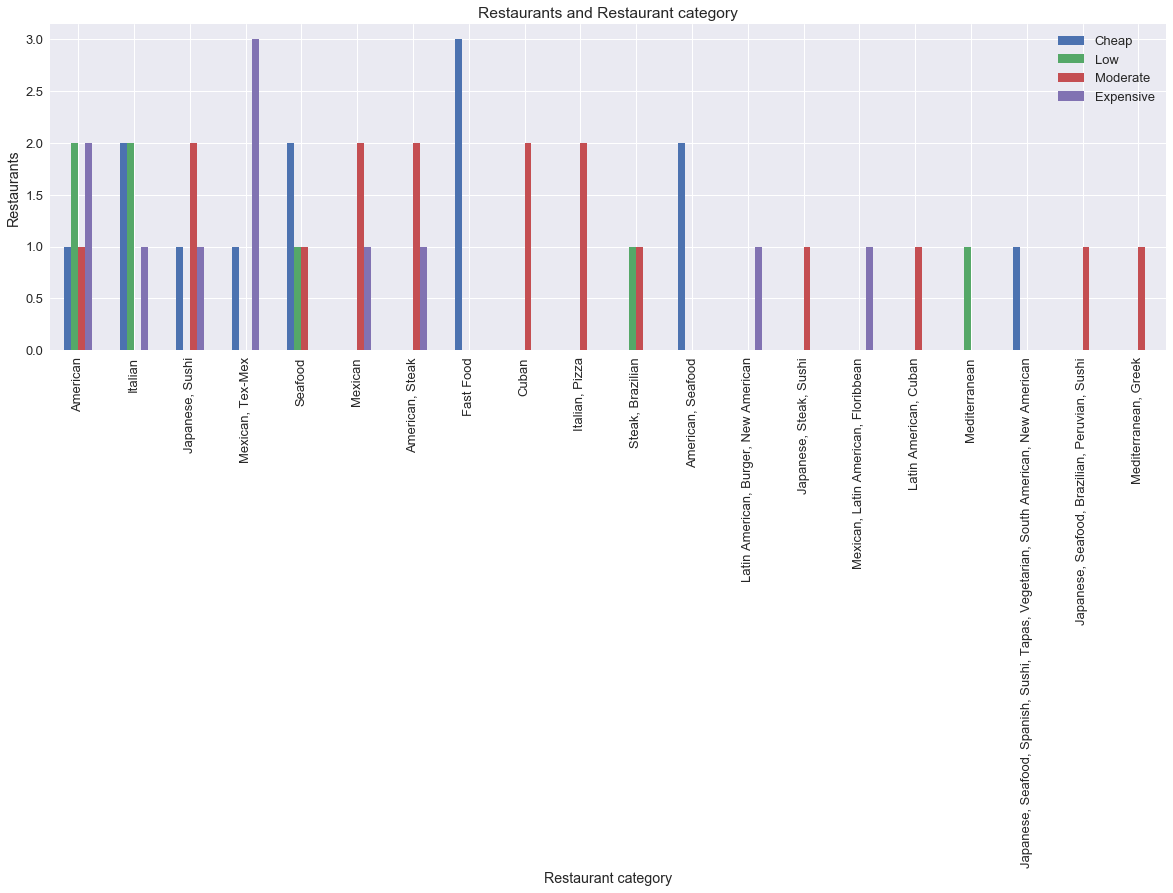

In [169]:
sns.set(font_scale=1.3)
fig, ax = plt.subplots(figsize=(20,6))
df = pd.crosstab(zomato.category,zomato.price_segment)
df.columns = ['Cheap','Low','Moderate','Expensive']
df['total'] = df['Cheap']+df['Low']+ df['Moderate']+ df['Expensive']
df = df.sort_values('total', ascending=False)
del df['total']
df.head(20).plot(ax=ax, kind='bar')
plt.title('Restaurants and Restaurant category')
plt.xlabel('Restaurant category')
plt.ylabel('Restaurants')
plt.show()

# Trip Advisor

In [170]:
# There are in total 3600 restaurants
ta.rating.str[-5:].unique()

array(['3,600', nan], dtype=object)

# Converting the restaurant ranking to rating

In [125]:
# Extracting the ranking for each restaurant

ta['rating'] = ta.rating.str.split(' ').str[0].str.replace(',','')

In [126]:
# Dividing the restaurants on a scale of 3,600 total restaurants in Miami

ta['rating'] = ta['rating'].astype(float)/3600

In [127]:
# Converting to a 5-scale

ta['ratingpercentile'] = pd.qcut(ta.rating,100, labels=False)

In [128]:
ta['ratingbucket'] = np.where(ta.rating.isnull(), np.nan, 5.0)

# Top 10 percentile with rating 5
ta['ratingbucket'][ta['ratingpercentile'] > 10] = 4.5
# 10-30 percentile with 4.5
ta['ratingbucket'][ta['ratingpercentile'] > 30] = 4.0
# 30 -60 with 3.5
ta['ratingbucket'][ta['ratingpercentile'] > 60] = 3.5
# 60 - 80 with 3.0
ta['ratingbucket'][ta['ratingpercentile'] > 80] = 3.0
# 80 - 90 with 2.5
ta['ratingbucket'][ta['ratingpercentile'] > 90] = 2.5

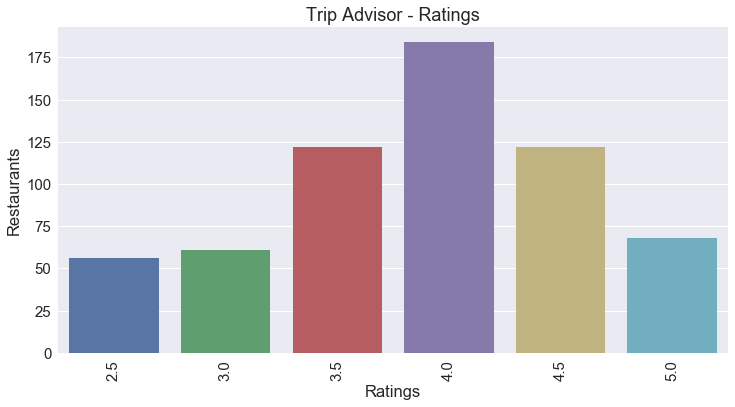

In [129]:
ta = ta.sort_values('rating', ascending=False)

sns.set(font_scale= 1.5)
fig, ax = plt.subplots(figsize=(12,6))
sns.countplot(ax = ax, x='ratingbucket', data=ta)
plt.title('Trip Advisor - Ratings')
plt.xlabel('Ratings')
plt.ylabel('Restaurants')
plt.xticks(rotation=90)
plt.show()

In [132]:
zomato.columns = ['zomato_category','name','zomato_price','zomato_rating','zomato_review_count','zomato_url'
       ,'zomato_zip','zomato_source','zomato_pricesegment','zomato_ratingbucket']

In [133]:
yelp.columns = ['yelp_category', 'name','yelp_price','yelp_rating','yelp_review_count','yelp_url','yelp_zip','yelp_source']

In [134]:
ta.columns = ['name','ta_url','ta_category','ta_zip','ta_price',
       'ta_review_count', 'ta_source', 'ta_rating', 'ta_ratingpercentile', 'ta_ratingbucket']

In [135]:
comb = pd.merge(ta, zomato, how = 'inner', on = 'name')

comb.shape

(3, 19)

In [139]:
comb2 = pd.merge( yelp,comb, how = 'inner', on = 'name')

comb2.shape

(4, 26)

## Rating comparison Yelp vs Ta vs Zomato

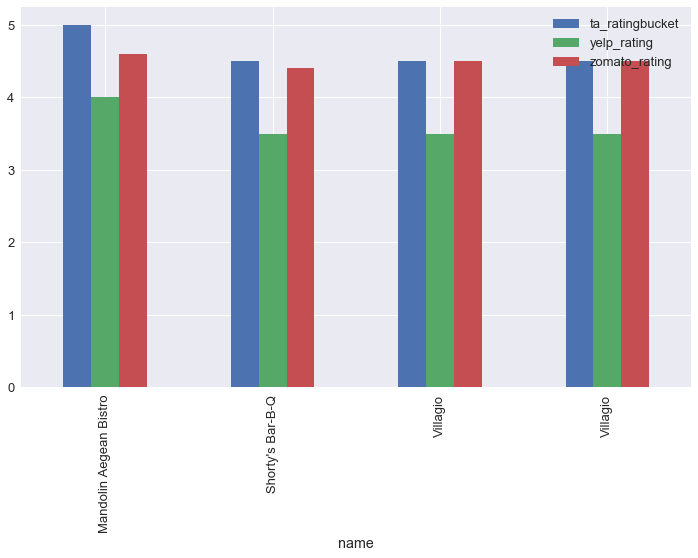

In [141]:
sns.set(font_scale=1.3)

comb2.plot(kind='bar', x = 'name',y = ['ta_ratingbucket','yelp_rating','zomato_rating'], figsize=(12,7))

plt.show()

## Rating comparison Yelp vs Zomato

In [142]:
comb3 = pd.merge(zomato, yelp, how = 'inner', on = 'name')

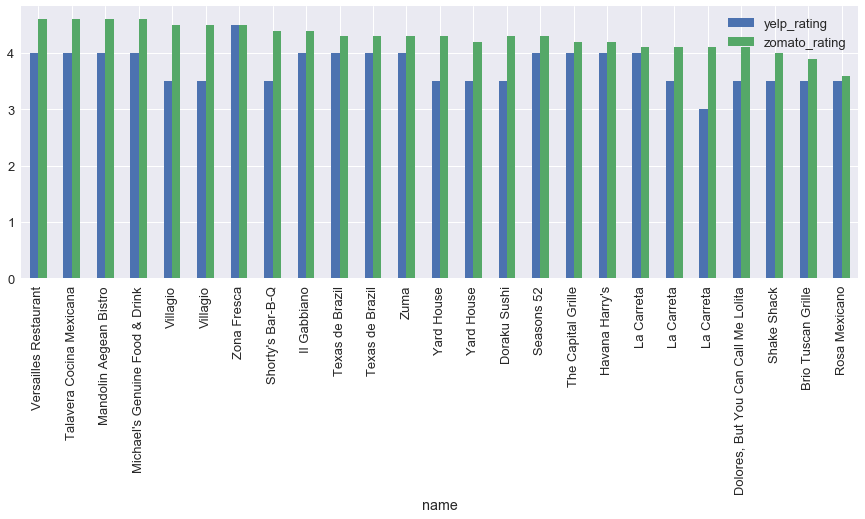

In [143]:
sns.set(font_scale=1.3)

comb3.plot(kind='bar', x = 'name',y = ['yelp_rating','zomato_rating'], figsize=(15,5))

plt.show()

Now that we see that there is substantial rating differences between same restaurants in Yelp and Zomato, we need to offer the users with possible reasons for the difference.
Below are few possible reasons:

1. Since we see ratings from Zomato is almost always higher than ratings from Yelp, we can speculate that there might be lesser number of reviews in Zomato as compared to Yelp. Number of reviews generally tends to reduce the average ratings of restaurants due to varied opinions. However, this is not mandatory. There are chances that people might have actually given higher ratings to same restaurant in Zomato. To find this out, we will need to tally the review count for the common restaurants across both the platforms.

# Review Count Comparison Yelp vs Zomato

In [144]:
comb4 = pd.merge(zomato, yelp, how = 'inner', on = 'name')

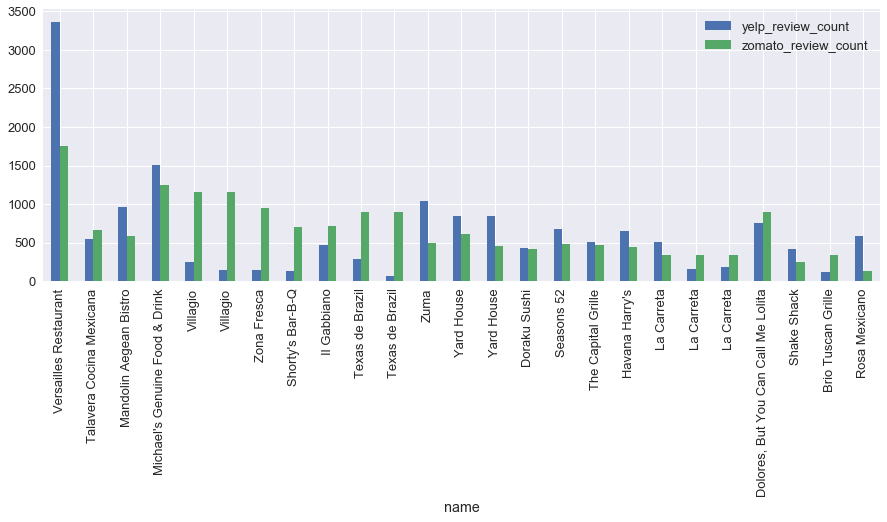

In [145]:
sns.set(font_scale=1.3)

comb4.plot(kind='bar', x = 'name',y = ['yelp_review_count','zomato_review_count'], figsize=(15,5))

plt.show()

The above graph validates our prediction for some of the restaurants. For the first restaurant "Versailles Restaurant", we see that the number of reviews of Yelp is substanitally higher than Zomato. This further suggests why rating in Zomato for the same restaurant is higher than the rating in Yelp. With the increase in visitors the restaurant probably was not able to maintain it's quality or probably there are higher number of people in Miami that use Yelp as compared to Zomato.
Similarly for "Villagio" we can see that the number of reviews in Zomato is higher than the number of reviews in Yelp. 

# Review Count Comparison Yelp vs Zomato vs Trip Advisor

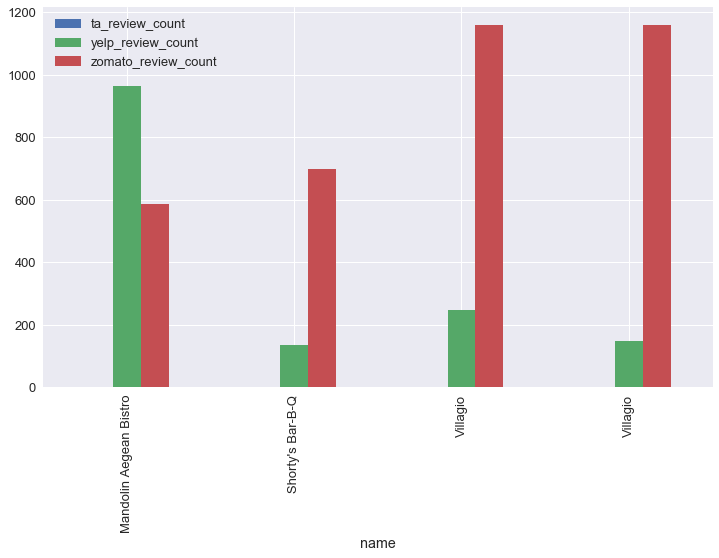

In [146]:
sns.set(font_scale=1.3)

comb2.plot(kind='bar', x = 'name',y = ['ta_review_count','yelp_review_count','zomato_review_count'], figsize=(12,7))

plt.show()

## Word Cloud by Zip code

In [147]:
df_reviews= pd.read_csv("../DataFiles/reviews_df.csv")

In [148]:
def datacleaning(df):
    #removing @
    df["reviews"]= df.apply(lambda row: re.sub(r'@[\w0-9]+','',row["reviews"],re.IGNORECASE), axis=1)
    #removing URL tags
    df["reviews"]= df.apply(lambda row: re.sub(r'https?://[\w0-9./]+','',row["reviews"],re.IGNORECASE), axis=1)
    df["reviews"]= df.apply(lambda row: re.sub(r'www.[^ ]+','',row["reviews"],re.IGNORECASE), axis=1)
    
    #removing Byte order marks
    df["reviews"]= df.apply(lambda row: row["reviews"].replace(u"\ufffd", "?"), axis=1)
    #Convert the data to lowercase
    df["reviews"]= df.apply(lambda row: row["reviews"].lower(), axis=1)    
    #removing hashtag/numbers and punctuations
    df["reviews"]= df.apply(lambda row: re.sub(r"[^a-zA-Z ]+",'',row["reviews"]), axis=1)
    return df
df_reviews = datacleaning(df_reviews)

In [149]:
def handle_length(text):
    tokenizer = nltk.tokenize.word_tokenize
    words = tokenizer(text)
    fin=[]
    for word in words:
        if len(word)>1:
            fin.append(word)
    return " ".join(fin)    
df_reviews["reviews"] = df_reviews["reviews"].apply(handle_length)

In [150]:
def filter_data_byzip(df,zip_code):
    df_ = df.copy()
    df_ = df_[df_["zip"]==zip_code]
    return " ".join(list(df_["reviews"]))

# Please select a zip code from the below list

In [151]:
def f(zip_code):
    reviews_list= filter_data_byzip(df_reviews,zip_code)
    wc = WordCloud(width=1600, height=800,max_font_size=200,stopwords=nltk.corpus.stopwords.words('english')\
                         , colormap="viridis").generate(reviews_list)
    plt.figure(figsize=(20,18))
    plt.imshow(wc, interpolation="bicubic")
    plt.axis("off")
    plt.show()
    return (wc,zip_code)
a= interactive(f, zip_code=df_reviews["zip"].unique());
display(a)
plt.show()

interactive(children=(Dropdown(description='zip_code', options=(33135, 33134, 33127, 33132, 33128, 33143, 33137, 33133, 33131, 33138, 33176, 33165, 33173, 33130, 33145, 33183, 33174, 33144, 33155, 33126, 33156, 33172, 33136, 33125, 33122, 33166, 33186, 33175, 33146, 33150, 33010, 33231, 33129, 33184, 33142, 33178, 33196, 33147, 33101, 33256, 33149, 33255), value=33135), Output()), _dom_classes=('widget-interact',))

In [220]:
data_new = pd.ExcelFile('../DataFiles/Final_Data.xlsx')
Total_data = data_new.parse("Merged_Data")
Total_data;

In [221]:
Total_data["zip"]= Total_data["zip"].astype(int,errors="ignore")
Total_data= Total_data[~Total_data["zip"].isnull()]
Total_data["zip"]= Total_data["zip"].astype(int)

In [232]:
new_df = Total_data[Total_data["zip"]==33135]
new_df = new_df[["name","rating","source","price","zip"]]

In [246]:
new_df[new_df.source=="Trip Advisor"]

,name,rating,source,price,zip
12768,Jacalito Taqueria,"225 of 3,600",Trip Advisor,NaN,33135
12859,La Prtena Cafeteria,NaN,Trip Advisor,NaN,33135
12895,Subway,NaN,Trip Advisor,NaN,33135
12942,El Cristo Restaurant,"59 of 3,600",Trip Advisor,NaN,33135
12997,McDonald's,"1,660 of 3,600",Trip Advisor,NaN,33135
13016,Guayacan Restaurant,"280 of 3,600",Trip Advisor,11 - 11,33135
13065,Tortilleria Truchita,NaN,Trip Advisor,NaN,33135
13075,McDonald's,"1,761 of 3,600",Trip Advisor,NaN,33135
13285,Domino's Pizza,NaN,Trip Advisor,NaN,33135
13320,Subway,"1,787 of 3,600",Trip Advisor,NaN,33135


In [239]:
new_df.source.unique()

array(['Yelp', 'Trip Advisor', 'Zomato'], dtype=object)

# Thank You!